In [17]:
import plotly.express as px
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.auto import tqdm
from pandarallel import pandarallel

tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
# Load and preprocess the data
para_muni = gpd.read_file("outputs/para_muni.geojson")
hex_gdf = gpd.read_parquet("outputs/02072024_para_hexs_final.parquet")

In [3]:
# Number of Regions in Pará
para_muni["name_region"].unique()

array(['Norte'], dtype=object)

In [4]:
# Validate we only have municipalities of Pará
para_muni["abbrev_state"].unique()

array(['PA'], dtype=object)

In [5]:
# Number of Municipalities in Para
para_muni["name_muni"].nunique()

144

In [6]:
para_muni.shape

(144, 8)

In [7]:
para_muni.columns

Index(['code_muni', 'name_muni', 'code_state', 'abbrev_state', 'name_state',
       'code_region', 'name_region', 'geometry'],
      dtype='object')

In [8]:
hex_gdf.shape

(1501128, 214)

In [11]:
# Change the name of V002_adj to population_br_censo_2020
hex_gdf = hex_gdf.rename(columns={"V002_adj": "population_br_censo_2020"})
hex_gdf = hex_gdf.rename(columns={"V003_adj": "income_reais_br_censo_2020"})

In [15]:
# Add name of the municipality to the hexagon
hex_gdf = gpd.sjoin(hex_gdf, para_muni[["name_muni", "geometry"]], how="left", op="within")

/Users/claudio/Documents/edu-brazil/.env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_2494/4103751948.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4674

  hex_gdf = gpd.sjoin(hex_gdf, para_muni[["name_muni", "geometry"]], how="left", op="within")


In [16]:
muni_gdf = gpd.GeoDataFrame(
    hex_gdf.groupby("name_muni")
    .agg(
        {
            # Sum all population columns
            "population_2020": "sum",
            "pop_3_5_years_adj": "sum",
            "pop_6_14_years_adj": "sum",
            "pop_15_17_years_adj": "sum",
            "pop_18_years_adj": "sum",
            "population_br_censo_2020": "sum",
            # Calculate the average income
            "income_reais_br_censo_2020": "mean",
            "income_pc": "mean",
            # Count all schools
            "ensino_fundamental": "sum",
            "educacao_infantil": "sum",
            "ensino_medio": "sum",
            "educacao_jovens_adultos": "sum",
            "educacao_profissional": "sum",
            "no_specified": "sum",
            # Count all private/public schools
            "privada": "sum",
            "publica": "sum",
            # Count all types of public schools
            "federal": "sum",
            "estadual": "sum",
            "municipal": "sum",
        }
    )
    .merge(para_muni[["name_muni", "geometry"]], on="name_muni"),
    geometry="geometry",
)

In [18]:
# Plot all variables at municipality level
for col in muni_gdf.columns:
    if col not in ["name_muni", "geometry"]:
        muni_gdf.plot(col, legend=True, figsize=(20, 10))
        plt.title(col.replace("_", " ").title())
        plt.axis("off")
        # Save the plot
        output_fn = Path(f"outputs/maps/munis/munis_{col}.png")
        output_fn.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(output_fn, dpi=300, bbox_inches="tight")
        # Do not show the plot
        plt.close()

In [19]:
selected_municipality = "Belém"

In [20]:
muni_hexagons = hex_gdf[hex_gdf["name_muni"] == selected_municipality]

In [57]:
education_levels = ["INF_CRE", "INF_PRE", "FUND_AI", "FUND_AF", "MED"]

In [58]:
# Calculate defaults for the table
for level in education_levels:

    hex_gdf[f"QT_MAT_{level}_PROP"] = hex_gdf[f"QT_MAT_{level}"] / hex_gdf["QT_MAT_BAS"]
    
    hex_gdf[f"PROP_TURNO_COMPLETO_{level}"] = (
        hex_gdf[f"QT_MAT_{level}_INT"] / hex_gdf[f"QT_MAT_{level}"]
    )

    # Initialize variables
    hex_gdf[f"PROP_TURNO_NOCTURNO_{level}"] = np.nan
    hex_gdf[f"QT_PUESTOS_{level}"] = np.nan

    if level in ["INF_CRE", "INF_PRE", "FUND_AI"]:
        hex_gdf[f"PROP_TURNO_NOCTURNO_{level}"] = (
            "N/A"  # Small children don't attend night classes
        )
        hex_gdf[f"QT_PUESTOS_{level}"] = hex_gdf[f"QT_MAT_{level}"] * (
            1 + hex_gdf[f"PROP_TURNO_COMPLETO_{level}"]
        )
    else:
        hex_gdf[f"PROP_TURNO_NOCTURNO_{level}"] = (
            hex_gdf["QT_MAT_BAS_N"] * hex_gdf[f"QT_MAT_{level}_PROP"]
        )
        hex_gdf[f"QT_PUESTOS_{level}"] = (
            hex_gdf[f"QT_MAT_{level}"]
            * (1 + hex_gdf[f"PROP_TURNO_COMPLETO_{level}"])
            * (1 - hex_gdf[f"PROP_TURNO_NOCTURNO_{level}"])
        )

In [59]:
belem_hexs = hex_gdf[hex_gdf["name_muni"] == "Belém"]
belem_hexs.shape

(1110, 236)

In [60]:
main_table = []
# total number of students on each level
main_table.append(belem_hexs[[f'QT_MAT_{level}' for level in education_levels]].sum().values.tolist())
# percentage of students in integral time (Tempo Integral)
main_table.append([belem_hexs[f"QT_MAT_{level}_INT"].sum() / belem_hexs[f"QT_MAT_{level}"].sum() for level in education_levels])
# percentage of students in nocturnal time (Tempo Noturno)
main_table.append([
    (belem_hexs["QT_MAT_BAS_N"] * belem_hexs[f"QT_MAT_{level}_PROP"]).sum() / belem_hexs[f"QT_MAT_{level}"].sum()
    if level not in ["INF_CRE", "INF_PRE", "FUND_AI"] else 0 
    for level in education_levels 
])
# total number of places available
total_places = []
for i, level in enumerate(education_levels):
    # total number of students * (1 + percentage of students in integral time) * (1 - percentage of students in nocturnal time
    num_cadeiras = main_table[0][i] * (1 + main_table[1][i]) * (1 - main_table[2][i])
    total_places.append(num_cadeiras)
main_table.append(total_places)

main_table = pd.DataFrame(main_table, columns=education_levels, index=["Total Alunos", "Integral (%)", "Nocturno (%)", "Num. Cadeiras"])
main_table

,INF_CRE,INF_PRE,FUND_AI,FUND_AF,MED
Total Alunos,6874.000000,16518.00000,65398.0000,59785.000000,47577.000000
Integral (%),0.612598,0.13791,0.0239,0.020708,0.066061
Nocturno (%),0.000000,0.00000,0.0000,0.097799,0.111349
Num. Cadeiras,11085.000000,18796.00000,66961.0000,55054.985983,45072.394891


In [61]:
# Calculate the number of classrooms needed based on the user defined number of chairs per classroom

# Number of chairs per classroom
num_chairs = 30

# Number of classrooms needed in total
main_table.loc["Num. Salas Total"] = main_table.loc["Num. Cadeiras"] / num_chairs

# Actual number of classrooms
main_table.loc["Num. Salas Atuais"] = [(belem_hexs["QT_SALAS_UTILIZADAS"] * belem_hexs[f"QT_MAT_{level}_PROP"]).sum() for level in education_levels]

# Number of classrooms needed in each level
main_table.loc["Num. Salas Novas"] = np.ceil(
    np.maximum(main_table.loc["Num. Salas Total"] - main_table.loc["Num. Salas Atuais"], 0)
)

main_table

,INF_CRE,INF_PRE,FUND_AI,FUND_AF,MED
Total Alunos,6874.000000,16518.000000,65398.000000,59785.000000,47577.000000
Integral (%),0.612598,0.137910,0.023900,0.020708,0.066061
Nocturno (%),0.000000,0.000000,0.000000,0.097799,0.111349
Num. Cadeiras,11085.000000,18796.000000,66961.000000,55054.985983,45072.394891
Num. Salas Total,369.500000,626.533333,2232.033333,1835.166199,1502.413163
Num. Salas Atuais,203.597353,458.511232,1705.055450,1578.935521,1265.527952
Num. Salas Novas,166.000000,169.000000,527.000000,257.000000,237.000000


In [65]:
creche = "INF_CRE"
hex_gdf[
    [
        f"QT_MAT_{level}",  # Total de Estudantes
        f"PROP_TURNO_COMPLETO_{creche}",  # % Tempo Integral
        f"PROP_TURNO_NOCTURNO_{creche}",  # % Noturno
        f"QT_PUESTOS_{creche}",  # # de cadeiras
    ]
].dropna().round()

,QT_MAT_MED,PROP_TURNO_COMPLETO_INF_CRE,PROP_TURNO_NOCTURNO_INF_CRE,QT_PUESTOS_INF_CRE
2415,0.0,0.0,N/A,13.0
3608,1110.0,0.0,N/A,183.0
4261,0.0,0.0,N/A,4.0
5114,0.0,1.0,N/A,156.0
5325,0.0,0.0,N/A,78.0
...,...,...,...,...
1498628,0.0,0.0,N/A,12.0
1499491,0.0,0.0,N/A,8.0
1500040,0.0,0.0,N/A,14.0
1500596,0.0,0.0,N/A,17.0


In [67]:
# Calculate the number of classrooms needed based on the user defined number of chairs per classroom
puestos_por_sala = 30
for level in education_levels:
    hex_gdf[f"QT_SALAS_NECESARIAS_TOTAL_{level}"] = (
        hex_gdf[f"QT_PUESTOS_{level}"] / puestos_por_sala
    )
    hex_gdf[f"QT_SALAS_ACTUALES_{level}"] = (
        hex_gdf["QT_SALAS_UTILIZADAS"] * hex_gdf[f"QT_MAT_{level}_PROP"]
    )
    hex_gdf[f"QT_SALAS_NECESARIAS_EXTRA_{level}"] = np.ceil(
        np.maximum(
            hex_gdf[f"QT_SALAS_NECESARIAS_TOTAL_{level}"]
            - hex_gdf[f"QT_SALAS_ACTUALES_{level}"],
            0,
        )
    )

In [69]:
hex_gdf.to_parquet("outputs/180724_dashboard_hexs.parquet")

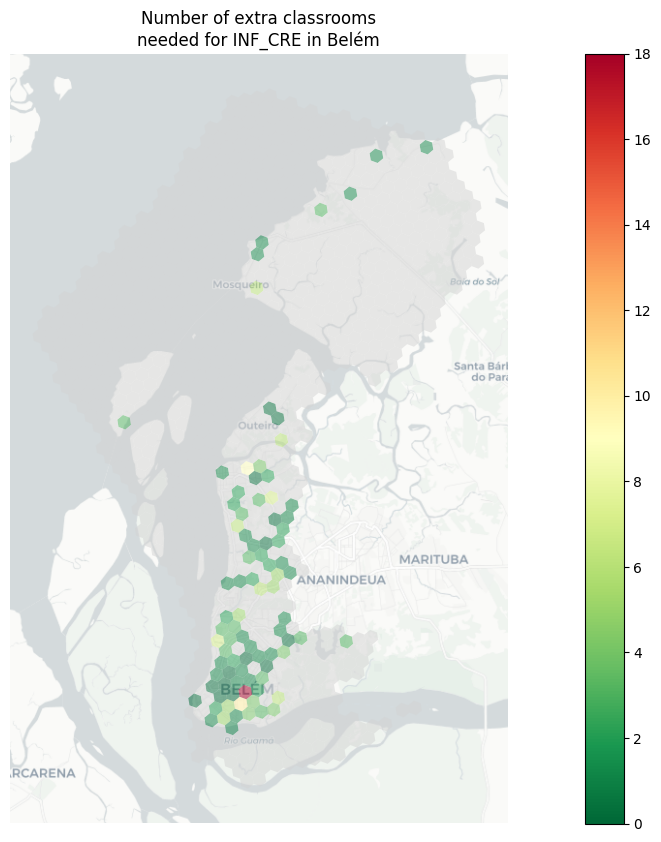

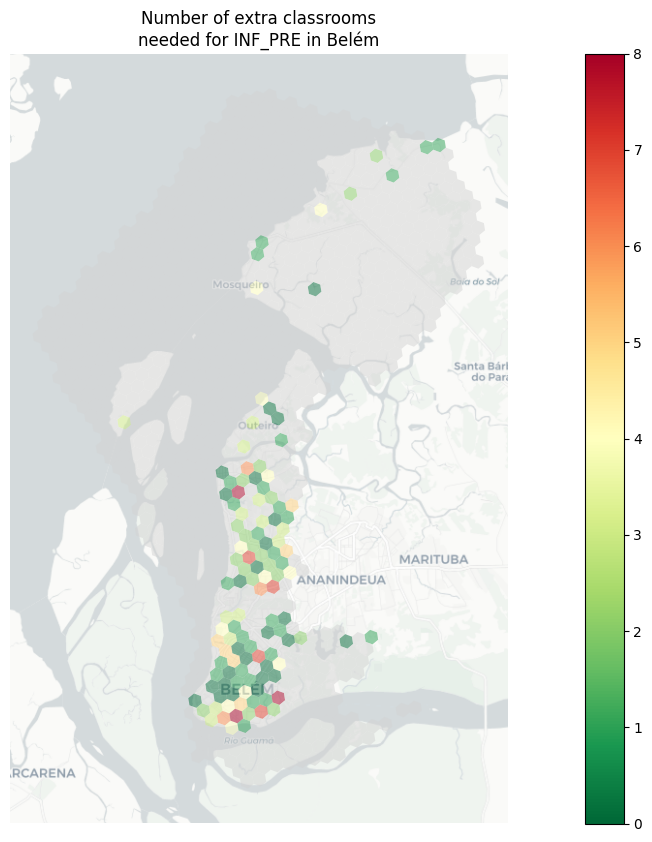

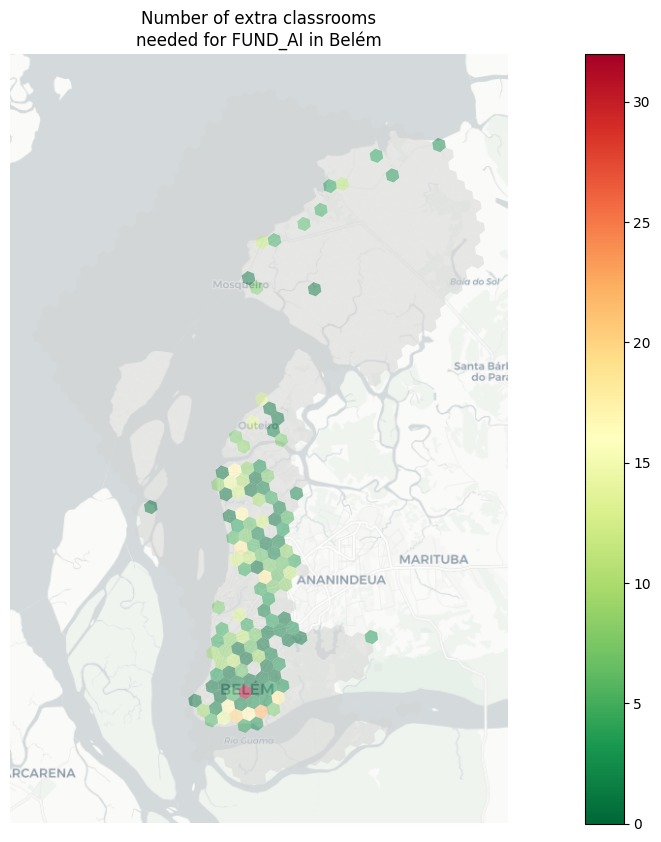

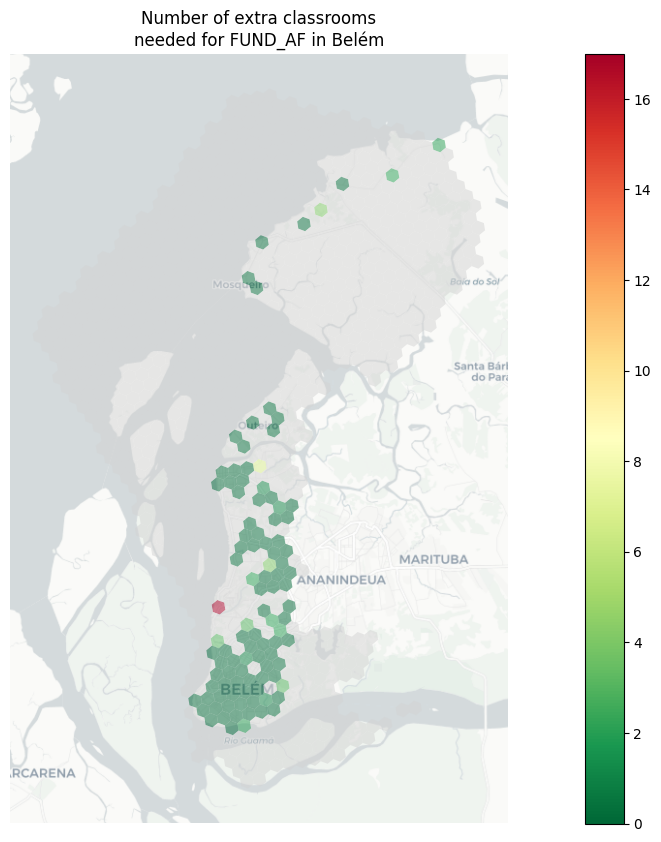

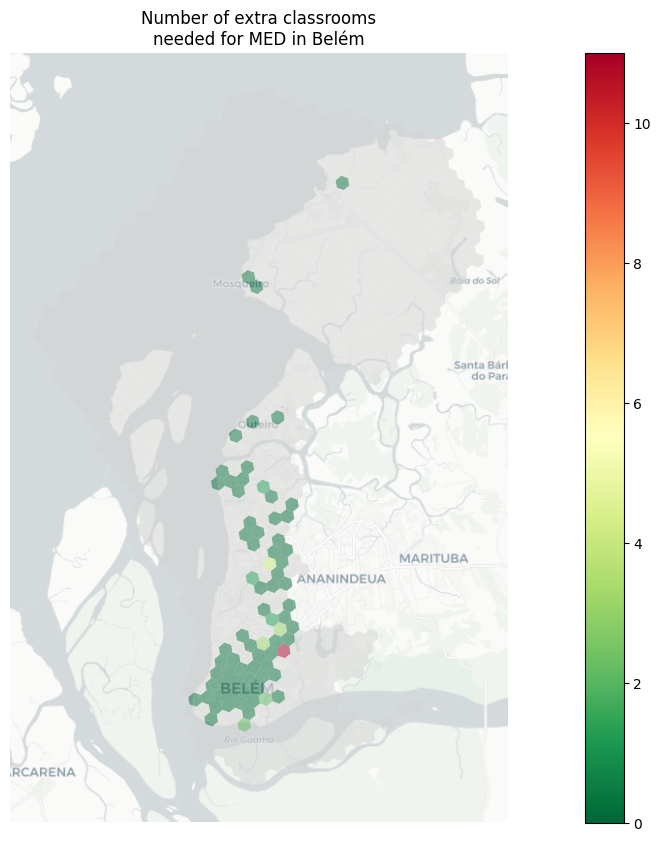

In [68]:
# Visualize the results for the selected municipality
belem_hexs = hex_gdf[hex_gdf["name_muni"] == "Belém"]
for level in education_levels:
    ax = belem_hexs.plot(
        f"QT_SALAS_NECESARIAS_EXTRA_{level}",
        alpha=0.5,
        legend=True,
        cmap="RdYlGn_r",
        figsize=(20, 10),
        missing_kwds={"color": "lightgrey"},
    )
    ax.set_axis_off()
    ax.set_title(f"Number of extra classrooms\nneeded for {level} in Belém")
    # Add a basemap
    ctx.add_basemap(
        ax, source=ctx.providers.CartoDB.Positron, crs=belem_hexs.crs, attribution=""
    )
    plt.show()

In [ ]:
# Plot the selected hexagon borders
ax = selected_hexagon.plot(edgecolor="red", facecolor="none", figsize=(20, 10))
schools.clip(belem_hexs).plot(color="red", ax=ax, alpha=0.5)

# Set axis limits to belem
minx, miny, maxx, maxy = selected_hexagon.total_bounds + np.array(
    [-0.01, -0.01, 0.01, 0.01]
)
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

ax.set_axis_off()

ax.set_title("Selected hexagon with schools")

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=belem_hexs.crs)

In [ ]:
# Get the index of the hexagon with the highest number of students
selected_hexagon = belem_hexs.loc[[belem_hexs["ensino_fundamental"].idxmax()]]

In [ ]:
# Plot the selected hexagon borders
ax = selected_hexagon.plot(edgecolor="red", facecolor="none", figsize=(20, 10))
belem_hexs.plot("ensino_fundamental", ax=ax, alpha=0.5, legend=True)

# Set axis limits to belem
minx, miny, maxx, maxy = belem_hexs.total_bounds
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

ax.set_axis_off()

ax.set_title("Number of students in elementary school in Belém")

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=belem_hexs.crs)

In [ ]:
schools = gpd.read_parquet("outputs/20240129_para_schools_final.parquet")
schools.to_crs(belem_hexs.crs, inplace=True)

In [ ]:
schools.clip(selected_hexagon).shape

In [ ]:
schools.clip(belem_hexs).shape

In [ ]:
creche = "INF_CRE"

In [ ]:
newhex_gdf = hex_gdf.copy()

In [ ]:
del hex_gdf

In [ ]:
hex_gdf = newhex_gdf.copy()

In [ ]:
education_levels

In [ ]:
def plot_municipality_extra_classrooms(muni: str):
    # Visualize the results for the selected municipality
    muni_hexs = hex_gdf[hex_gdf["name_muni"] == muni]

    # Create a figure with one map for each level
    fig, axes = plt.subplots(
        1, len(education_levels), figsize=(len(education_levels) * 10, 8)
    )

    fig.suptitle(f"Number of extra classrooms needed in {muni}", fontsize=16)

    v_min = muni_hexs[[f"QT_SALAS_NECESARIAS_EXTRA_{level}" for level in education_levels]].min().min()
    v_max = muni_hexs[[f"QT_SALAS_NECESARIAS_EXTRA_{level}" for level in education_levels]].max().max()

    for i, level in enumerate(education_levels):
        plot_params = dict(
            alpha=0.5,
            legend=False,
            cmap="RdYlGn_r",
            ax=axes[i],
            missing_kwds={"color": "lightgrey"},
        )
        if i == len(education_levels) - 1:
            divider = make_axes_locatable(axes[i])
            plot_params["cax"] = divider.append_axes("right", size="5%", pad=0.1)
            plot_params["legend"] = True
            plot_params["vmin"] = v_min
            plot_params["vmax"] = v_max
        ax = muni_hexs.plot(f"QT_SALAS_NECESARIAS_EXTRA_{level}", **plot_params)
        ax.set_axis_off()
        ax.set_title(f"Edu Level: {level}")
        ctx.add_basemap(
            ax, source=ctx.providers.CartoDB.Positron, crs=hex_gdf.crs, attribution=""
        )

    plt.tight_layout()

    output_filename = (
        Path("outputs/maps/para_extra_classrooms") / f"{muni}_extra_classrooms.png"
    )
    output_filename.parent.mkdir(parents=True, exist_ok=True)

    if not output_filename.exists():
        plt.savefig(output_filename, dpi=300, bbox_inches="tight")

In [ ]:
muni_gdf.shape

In [ ]:
muni_gdf.parallel_apply(lambda x: plot_municipality_extra_classrooms(x["name_muni"]), axis=1)

In [ ]:
metrics_per_education_level = {}

for level in education_levels:

    number_of_students = hex_gdf[f"QT_MAT_{level}"].sum().round()

    full_time_percentage = (
        hex_gdf[f"QT_MAT_{level}_INT"].sum() / number_of_students * 100
    ).round(2)

    if level in ["INF_CRE", "INF_PRE", "FUND_AI"]:
        night_percentage = "N/A"  # Small children don't attend night classes
    else:
        night_percentage = (
            hex_gdf[f"QT_MAT_{level}_N"].sum() / number_of_students * 100
        ).round(2)

    number_of_chairs = number_of_students * (
        1 + full_time_percentage / number_of_students
    ).round(2)

    total_classrooms = (number_of_chairs / chairs_per_classroom).round()

    current_classrooms = ()

In [ ]:
# Plot population by municipality

# Use sjoin to get the municipality of each hexagon
hex_gdf = gpd.sjoin(hex_gdf, para_muni, how="left", op="intersects")

# Group hexagons by municipality and calculate the population sum for all population columns
pop_cols = [col for col in hex_gdf.columns if "pop" in col]
pop_by_muni = hex_gdf.groupby("name_muni")[pop_cols].sum().reset_index()

# Use merge to get the geometry of the municipalities
pop_by_muni = pop_by_muni.merge(para_muni[["name_muni", "geometry"]], on="name_muni")

# Plot the population of each municipality
fig = px.choropleth_mapbox(
    pop_by_muni,
    geojson=pop_by_muni.geometry,
    locations=pop_by_muni.index,
    color="pop_total",
    mapbox_style="carto-positron",
    center={"lat": -3.29, "lon": -52.71},
    zoom=5,
    opacity=0.5,
    labels={"pop_total": "Population"},
)

In [ ]:
# Group hexagons by municipality and calculate the population sum for all population columns

In [ ]:
'hex',
 'geometry',
# Population 
 'population_2020',
 'pop_3_5_years_adj',
 'pop_6_14_years_adj',
 'pop_15_17_years_adj',
 'pop_18_years_adj',
# Socioeconomic
 'V002_adj', # Number of residents
 'V003_adj', # Number of residents with income 
 'income_pc',
'urban_area'
# Schools
## Count by level
 'ensino_fundamental',
 'educacao_infantil',
 'ensino_medio',
 'educacao_jovens_adultos',
 'educacao_profissional',
 'no_specified',
# Count by private/public
 'privada',
 'publica',
# Count by type of public school
'federal',
 'estadual',
 'municipal',

In [ ]:
import geopandas as gpd
import contextily as ctx

import matplotlib.pyplot as plt

# Define the columns to plot
columns = [
    "population_2020",
    "pop_3_5_years_adj",
    "pop_6_14_years_adj",
    "pop_15_17_years_adj",
    "pop_18_years_adj",
]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(15, 5))

# Set a shared colorscale for all the maps
vmin = hex_gdf[columns].min().min()
vmax = hex_gdf[columns].max().max()

# Plot choropleth maps for each column
for i, column in enumerate(columns):
    # Plot the choropleth map
    hex_gdf.plot(
        column=column,
        cmap="Blues",
        linewidth=0.8,
        ax=axes[i],
        edgecolor="0.8",
        legend=False,
    )

    # Set plot title with clean labels
    clean_label = column.replace("_", " ").title()
    axes[i].set_title(clean_label)

    # Remove axis ticks
    axes[i].set_xticks([])
    axes[i].set_yticks([])

    # Add basemap using contextily
    ctx.add_basemap(
        ax=axes[i], crs=hex_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron
    )

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
education_levels = ["INF_CRE", "INF_PRE", "FUND_AI", "FUND_AF", "MED"]
metrics_per_education_level = {}
for level in education_levels:
    number_of_students = hex_gdf[f"QT_MAT_{level}"].sum().round()
    full_time_percentage = (
        hex_gdf[f"QT_MAT_{level}_INT"].sum() / number_of_students * 100
    ).round(2)
    if level in ["INF_CRE", "INF_PRE", "FUND_AI"]:
        night_percentage = "N/A"  # Small children don't attend night classes
    else:
        night_percentage = (
            hex_gdf[f"QT_MAT_{level}_N"].sum() / number_of_students * 100
        ).round(2)
    number_of_chairs = number_of_students * (
        1 + full_time_percentage / number_of_students
    ).round(2)
    total_classrooms = (number_of_chairs / chairs_per_classroom).round()
    current_classrooms = ()

In [ ]:
def calculate_table_data(hex_gdf):
    # Placeholder values for the number of chairs per classroom
    chairs_per_classroom = 25

    education_levels = ["INF_CRE", "INF_PRE", "FUND_AI", "FUND_AF", "MED"]
    metrics_per_education_level = {}
    for level in education_levels:
        number_of_students = hex_gdf[f"QT_MAT_{level}"].sum().round()
        full_time_percentage = (
            hex_gdf[f"QT_MAT_{level}_INT"].sum() / number_of_students * 100
        ).round(2)
        if level in ["INF_CRE", "INF_PRE", "FUND_AI"]:
            night_percentage = "N/A"  # Small children don't attend night classes
        else:
            night_percentage = (
                hex_gdf[f"QT_MAT_{level}_N"].sum() / number_of_students * 100
            ).round(2)
        number_of_chairs = number_of_students * (
            1 + full_time_percentage / number_of_students
        ).round(2)
        total_classrooms = (number_of_chairs / chairs_per_classroom).round()
        current_classrooms = ()

    return table_data

In [ ]:
if not selected_municipality:
    return ""
# Filter the hexagons for the selected municipality
muni_hexagons = hex_gdf[
    hex_gdf.intersects(
        para_muni[para_muni["name_muni"] == selected_municipality].geometry.iloc[0]
    )
]
# Calculate the values for each metric
print([col for col in muni_hexagons.columns if "QT_MAT" in col])

# Placeholder values for the number of chairs per classroom
number_of_chairs_per_students = 25

In [ ]:
 # Calculate the values for each metric
    table_data = pd.DataFrame(
        {
            "Metric": [
                "Alunos",
                "% Tempo Integral",
                "% Noturno",
                "# de Cadeiras",
                "# Cadeiras / Sala",
                "Total Salas Necessárias",
                "Salas Atuais",
                "Salas Faltantes",
            ],
            "Creche": [
                int(hex_gdf["QT_MAT_INF_CRE"].sum()),
                round(
                    hex_gdf["QT_MAT_INF_CRE_INT"].sum()
                    / hex_gdf["QT_MAT_INF_CRE"].sum()
                    * 100,
                    2,
                ),
                "N/A",
                int(
                    hex_gdf["QT_MAT_INF_CRE"].sum()
                    * (
                        1
                        + hex_gdf["QT_MAT_INF_CRE_INT"].sum()
                        / hex_gdf["QT_MAT_INF_CRE"].sum()
                    )
                ),
                number_of_chairs_per_students,
                int(
                    hex_gdf["QT_MAT_INF_CRE"].sum()
                    * (
                        1
                        + hex_gdf["QT_MAT_INF_CRE_INT"].sum()
                        / hex_gdf["QT_MAT_INF_CRE"].sum()
                    )
                    / number_of_chairs_per_students
                ),
                np.nan,
                np.nan,
            ],
            "Pre-escola": [
                int(hex_gdf["QT_MAT_INF_PRE"].sum()),
                round(
                    hex_gdf["QT_MAT_INF_PRE_INT"].sum()
                    / hex_gdf["QT_MAT_INF_PRE"].sum()
                    * 100,
                    2,
                ),
                "N/A",
                int(hex_gdf["QT_MAT_MED"].sum()),
                round(
                    hex_gdf["QT_MAT_MED_INT"].sum() / hex_gdf["QT_MAT_MED"].sum() * 100,
                    2,
                ),
                "N/A",
                int(
                    hex_gdf["QT_MAT_MED"].sum()
                    * (
                        1
                        + hex_gdf["QT_MAT_MED_INT"].sum() / hex_gdf["QT_MAT_MED"].sum()
                    )
                    * (1 - hex_gdf["QT_MAT_MED_N"].sum() / hex_gdf["QT_MAT_MED"].sum())
                ),
                number_of_chairs_per_students,
                int(
                    hex_gdf["QT_MAT_MED"].sum()
                    * (
                        1
                        + hex_gdf["QT_MAT_MED_INT"].sum() / hex_gdf["QT_MAT_MED"].sum()
                    )
                    * (1 - hex_gdf["QT_MAT_MED_N"].sum() / hex_gdf["QT_MAT_MED"].sum())
                    / number_of_chairs_per_students
                ),
                np.nan,
                np.nan,
            ],
        }
    )

In [ ]:
 if not selected_municipality:
        return ""
    # Filter the hexagons for the selected municipality
    muni_hexagons = hex_gdf[
        hex_gdf.intersects(
            para_muni[para_muni["name_muni"] == selected_municipality].geometry.iloc[0]
        )
    ]
    # Calculate the values for each metric
    print([col for col in muni_hexagons.columns if "QT_MAT" in col])

    # Placeholder values for the number of chairs per classroom
    number_of_chairs_per_students = 25
